In [163]:
from tqdm import tqdm 
import copy
import numpy as np
from scipy.special import digamma, loggamma
import time
import matplotlib.pyplot as plt

In [2]:
K = 20 # Number of topics
V = 50 # Number of terms in the vocabulary
N = 10 # Number of documents
M = 20 # Number of words per document
ETA = 0.5 # Hyperparameter for V-Dirichlet topics prior
ALPHA = 0.5 # Hyperparameter for K-Dirichlet topics proportion prior

def sim_LDA(K, V, N, M):
    # For each topic in k = 1,...,K, draw topic distributions
    BETA = np.random.dirichlet(ETA * np.ones(V), K)

    X = [] # Initialize empty list for complete collection of documents
    for i in range(N): # Iterate over number of documents i = 1,...,N
        THETA = np.random.dirichlet(ALPHA * np.ones(K), N) # Draw topic proportions
        x = []
        for _ in range(M): # Iterate over each word
            z_ij = np.random.choice(K, p=THETA[i]) # Draw topic assignment
            x_ij = np.random.choice(V, p=BETA[z_ij]) # Draw observed word
            x.append(x_ij)
        X.append(x)

    X = np.asarray(X) # Convert collection of documents to numpy array
    return X
X = sim_LDA(K, V, N, M)

In [176]:
def init_variation_params(X):
    N, M = X.shape
    LAMBDA = np.random.uniform(low=0.01, high=3.00, size=(K, V))
    GAMMA = np.ones(shape=(N, K))
    PHI = np.ones(shape=(N, M, K)) * 1/K

    return LAMBDA, GAMMA, PHI

In [197]:
def compute_ELBO(LAMBDA, GAMMA, PHI, X):
    N, M = X.shape
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_q_log_p_z_x = 0
    for i in range(N):
        for j in range(M):
            x_ij = X[i,j]
            E_q_log_p_z_x += np.sum(PHI[i,j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i,j] * (digamma(LAMBDA[:, x_ij])) - digamma(np.sum(LAMBDA[:, x_ij], axis=0)))
    ELBO = E_q_log_p_z_x

    E_log_q_BETA = 0
    for k in range(K):
        E_log_q_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_log_q_BETA

    E_log_q_THETA = 0
    for i in range(N):
        E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_log_q_THETA

    E_q_log_z = 0
    for i in range(N):
        for j in range(M):
            E_q_log_z += -np.sum(PHI[i,j] * np.log(PHI[i,j]))
    ELBO += E_q_log_z

    return ELBO

def log_sum_exp(vec):
    alpha = np.max(vec, axis=0)
    log_sum_exp = np.log(np.sum(np.exp(vec - alpha))) + alpha

    return log_sum_exp

In [198]:
print(compute_ELBO(LAMBDA, GAMMA, PHI, X))

for i in range(N):
    for j in range(M):
        v = X[i, j]
        exp_propto = digamma(LAMBDA[:, v]) - digamma(np.sum(LAMBDA[:, v])) + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
        PHI[i, j] = np.exp(exp_propto - log_sum_exp(exp_propto))

    for k in range(K):
        GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

for k in range(K):
    for v in range(V):
        LAMBDA[k, v] = ETA + np.sum([[float(X[i,j] == v) * PHI[i, j][k] for i in range(N)] for j in range(M)])

print(compute_ELBO(LAMBDA, GAMMA, PHI, X))

-407774.07823401684
-407013.56601589307


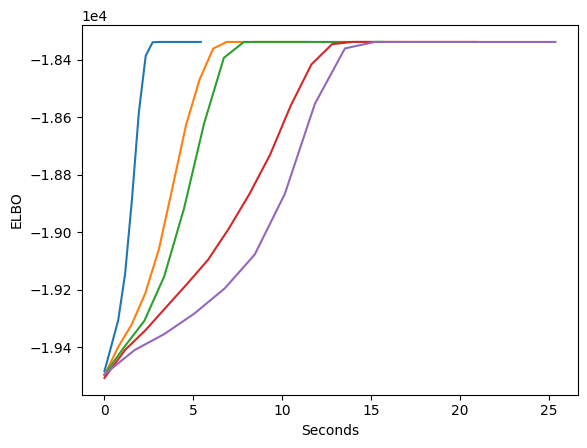

In [209]:
K = 10 # Number of topics
V = 50 # Number of terms in the vocabulary
N = 20 # Number of documents
M = 30 # Number of words per document
ETA = 0.5 # Hyperparameter for V-Dirichlet topics prior
ALPHA = 0.5 # Hyperparameter for K-Dirichlet topics proportion prior
X = sim_LDA(K, V, N, M) # Simulate LDA-collection of documents

start = time.time()
for _ in range(5):
    LAMBDA, GAMMA, PHI = init_variation_params(X)
    curr_ELBO = 100 # Initialize current ELBO value (initially arbitrarily greater than prev_ELBO)
    prev_ELBO = 0 # Initialize previous ELBO value (initially arbitrarily smaller than curr_ELBO)
    ELBOs = [] # Store ELBO values for plotting
    tol = 10e-10 # Tolerance for convergence of ELBO

    # Continue to update variational parameters until ELBO has converged with respect to tolerance (tol)
    while np.abs(curr_ELBO - prev_ELBO) > tol:
        # Update variational topic assignment PHI[i, j]
        for i in range(N):
            for j in range(M):
                # Again, x_ij is just an assignment of the vocabulary v=1,...,V so can treat it as such
                x_ij = X[i, j]

                # Calculate the expression inside the exponential for which PHI[i, j] is proportional to
                exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                    + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
                
                # Use log-sum-exp trick to normalize PHI[i, j] over k
                PHI[i, j] = np.exp(exp_propto - log_sum_exp(exp_propto))

            # Update variational topic proportions GAMMA[i]
            for k in range(K):
                # Update is ALPHA + sum_{j=1}^M PHI_ijk
                GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

        # Update variational topic LAMBDA[k]
        for k in range(K):
            for v in range(V):
                # Update is ETA + \sum_{i=1}^N \sum_{j=1}^M 1{x_ij = v} PHI_ijk
                LAMBDA[k, v] = ETA + np.sum([[float(X[i,j] == v) * PHI[i, j][k] for i in range(N)] for j in range(M)])
        
        prev_ELBO = curr_ELBO # Set the previous ELBO to the current value of previous iteration
        curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, X) # Compute ELBO for updated parameters; set current ELBO to new ELBO
        ELBOs.append(curr_ELBO) # Store computed ELBO values

    total_time = time.time() - start

    plt.xlabel("Seconds")
    plt.ylabel("ELBO")
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

    plt.plot(np.linspace(0, total_time, len(ELBOs)), ELBOs)

In [206]:
def init_variation_params(X):
    N, M = X.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.random.uniform(low=0.01, high=3.0, size=(N, K))
    PHI = np.ones(shape=(N, M, K)) * 1/K

    return LAMBDA, GAMMA, PHI